# Convolutional Neural Networks for Jet-Images
Author: Javier Duarte, Thong Nguyen

In [1]:
!fusermount -u drive

fusermount: failed to unmount /content/drive: No such file or directory


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'machine-learning-vbscan/'

Mounted at /content/gdrive


## Load numpy arrays
Here, we load the numpy arrays containing the 4D tensors of "jet-images" (see https://arxiv.org/pdf/1511.05190.pdf)

In [0]:
import h5py

h5f = h5py.File(base_dir+"data/jet_images.h5", "r")

jet_images_dict = {}
jet_images_dict['QCD'] = h5f['QCD'][()]
jet_images_dict['TT'] = h5f['TT'][()]

h5f.close()

In [4]:
# 4D tensor (tensorflow backend)
# 1st dim is jet index
# 2nd dim is eta bin
# 3rd dim is phi bin
# 4th dim is pt value (or rgb values, etc.)
print(jet_images_dict['QCD'].shape)
print(jet_images_dict['TT'].shape)

(3305, 30, 30, 1)
(1821, 30, 30, 1)


## Plotting jet-images
Let's plot some jet-images (individual jets and averaged over all jets)

**Question 1:**  Try to plot the average W and QCD jet-images.

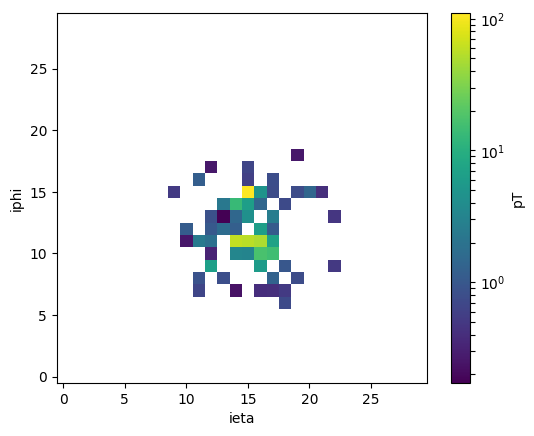

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline
plt.style.use('default')

# plot one W jet
i = 7
plt.figure('W') 
plt.imshow(jet_images_dict['TT'][i,:,:,0].T, norm=mpl.colors.LogNorm(), origin='lower', interpolation='none')
cbar = plt.colorbar()
cbar.set_label('pT')
plt.xlabel('ieta')
plt.ylabel('iphi')
plt.show()

# plot average W jet

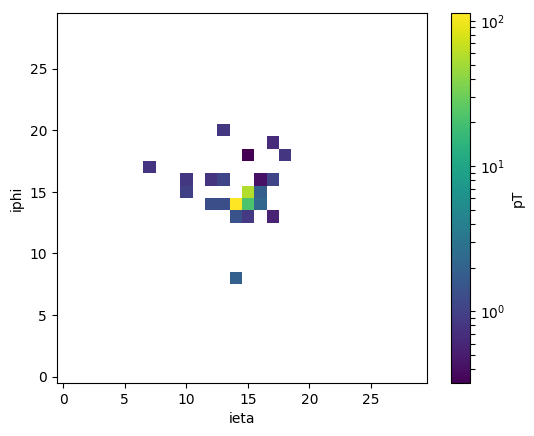

In [6]:
# plot one QCD jet
i = 7
plt.figure() 
plt.imshow(jet_images_dict['QCD'][i,:,:,0].T, norm=mpl.colors.LogNorm(), origin='lower', interpolation='none')
cbar = plt.colorbar()
cbar.set_label('pT')
plt.xlabel('ieta')
plt.ylabel('iphi')
plt.show()

# plot average QCD jet

## Define our convolutional model
**Question 2:** Here we have a relatively simple `Conv2D` model using regularization, batch normalization, max pooling, and a fully connected layer before the ouput. Implement the network defined in https://arxiv.org/pdf/1511.05190.pdf. Compare the performance and number of parameters when using fully connected layers instead of convolutional layers.

In [8]:
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dropout, Dense, BatchNormalization, Concatenate
from keras.regularizers import l1,l2
nx = 30
ny = 30
inputs = Input(shape=(nx, ny, 1), name='input')
x = Conv2D(8, (3, 3), 
           strides=(1, 1), 
           padding='same', 
           activation='relu', 
           name='conv2d_1', 
           kernel_regularizer=l2(0.01))(inputs)
x = BatchNormalization(momentum=0.6, name='batchnorm_1')(x)
x = MaxPool2D(pool_size=(2, 2), name='maxpool2d_1')(x)
x = Flatten(name='flatten')(x)
x = Dense(64, activation='relu', name='dense')(x)
outputs = Dense(1, activation='sigmoid', name='output')(x)
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 30, 30, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 8)         80        
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 30, 30, 8)         32        
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 15, 15, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1800)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                115264    
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total para

## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing).
**Note:**  We will not apply "image normalization" preprocessing: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html.
**Question 3:** Why not?

In [9]:
jet_images = np.concatenate([jet_images_dict['TT'],
                             jet_images_dict['QCD']])
jet_labels = np.concatenate([np.ones(len(jet_images_dict['TT'])), 
                             np.zeros(len(jet_images_dict['QCD']))])

X = jet_images
Y = jet_labels

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

print 'number of W jets for training/validation: %i'%np.sum(Y_train_val==1)
print 'number of QCD jets for training/validation: %i'%np.sum(Y_train_val==0)

print 'number of W jets for testing: %i'%np.sum(Y_test==1)
print 'number of QCD jets for testing: %i'%np.sum(Y_test==0)

# early stopping callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into conv2d_model.h5
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('conv2d_model.h5', monitor='val_loss', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)

number of W jets for training/validation: 1459
number of QCD jets for training/validation: 2641
number of W jets for testing: 362
number of QCD jets for testing: 664


## Run training
Here, we run the training.

In [10]:
# Train classifier
history = model.fit(X_train_val, Y_train_val, 
                    epochs=100, 
                    batch_size=1024, 
                    verbose=0, # switch to 1 for more verbosity
                    callbacks=[early_stopping, model_checkpoint], 
                    validation_split=0.25)

Instructions for updating:
Use tf.cast instead.


## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

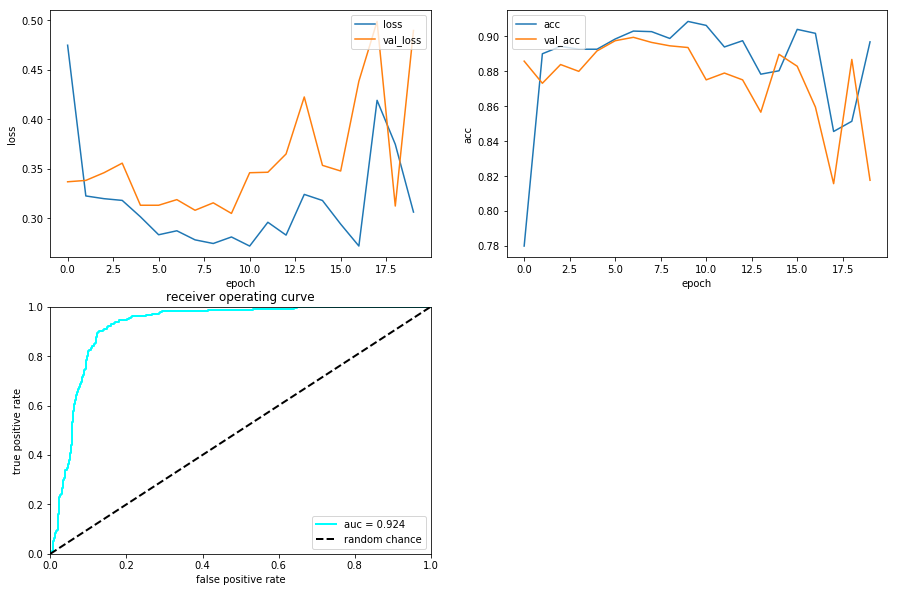

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['acc'], label='acc')
ax.plot(history.history['val_acc'], label='val_acc')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot ROC
Y_predict = model.predict(X_test)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
ax = plt.subplot(2, 2, 3)
ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_title('receiver operating curve')
ax.legend(loc="lower right")
plt.show()